# Web Crawling Algorithm

## What are Web Crawlers?

Web Crawlers are internet bots (programs) which systematically browse the Web in order to index webpages and collect information. Web crawlers are generally used by search engines and some other websites in order to update their content, indices of other websites, or databases.

## What are our objectives?

We will build a basic web crawler which will extract relevant data from our target webpage and store it in a Pandas dataframe  and .csv file.
For the purpose of this project, we have chosen three target webpages, given along with the data to be collected, as follows:
#### 1. PolitiFacts:
An American fact-checking initiative started by the Tampa Bay Times, and current owned by the Poynter Institute.

It labels statements on a scale of 6 labels: _"Pants on Fire"_, _"False"_, _"Barely True"_, _"Half True"_, _"Mostly True"_ and _"True"_.

**Collected content**: _Statement_; _Hyperlink_ (to the factcheck); _Date_; _Source_; _Label_
#### 2. The Guardian:
A British daily newspaper established in 1821, with an extensive digital edition freely available to all.

**Collected content**: _Headline_; _Hyperlink_; _Date_; _Full text_
#### 3. OpIndia:
An Indian right-wing digital propaganda outlet, which has been accused of publishing fake news on numerous occasions.

**Collected content**: _Headline_; _Hyperlink_; _Date_; _Full text_

## How would the program work?

#### Seed
To begin with, our program starts with a given link, called a _seed_. For our purpose, we will choose the first page of the list of articles on the website. As an example, let us use the PolitiFacts website.

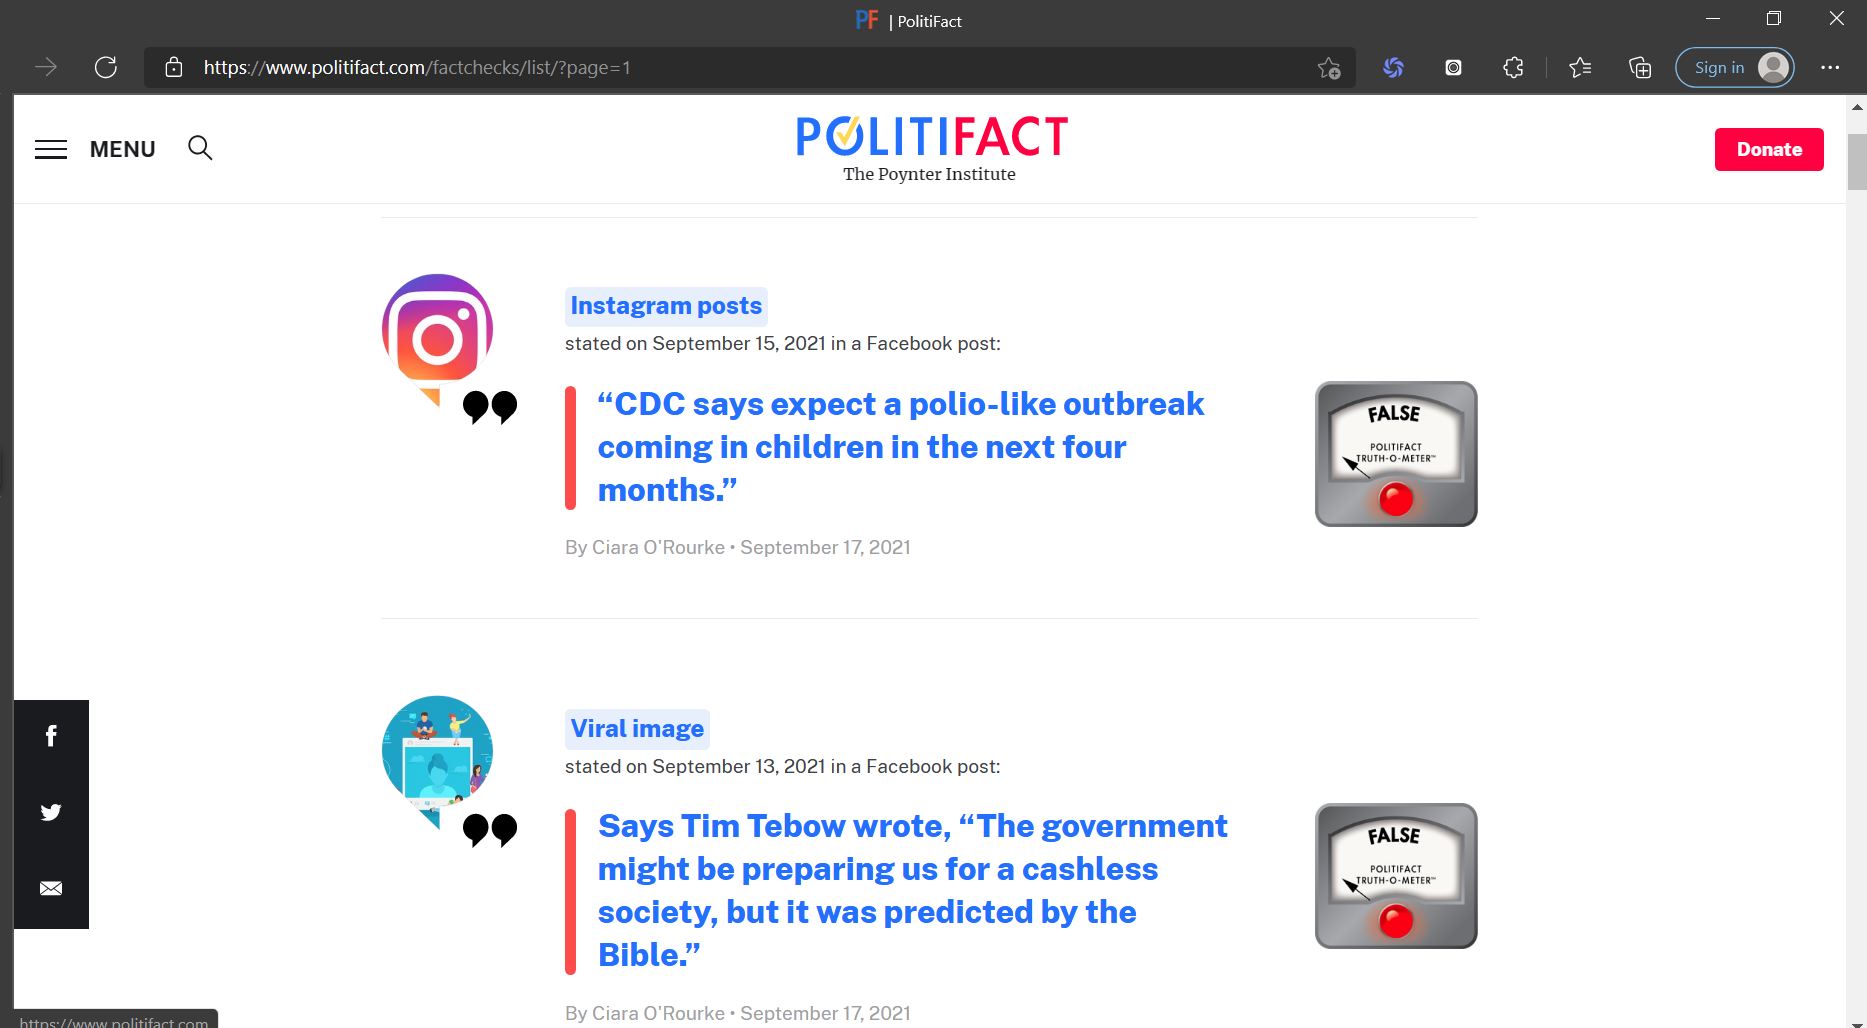

As you can see, the URL of this page is: `https://www.politifact.com/factchecks/list/?page=1`. This will be the seed for our web crawler.

#### Downloading web pages using HTTP
Now, the obvious first step is to download the web page at the seed link. When we do this manually, the web page is downloaded by our browser and displayed. When working with code, the web page will have to be downloaded and stored by the code we write. 

Hence, let's go deeper into the actual mechanics of this. Over the Internet, the usual protocol for transfering web pages is the Hyper Text Transfer Protocol (HTTP). HTTP is the foundation of data communication for the World Wide Web (WWW), and enables machines to request and send documents with hyperlinks and use hyperlinks to carry out requests. This is done through a HTTP session.

A typical HTTP session begins with the HTTP client establishing a TCP (Transmission Control Protocol) connection to a specific port on a server. Here, a HTTP server waits for a request from the client.

HTTP requests follow a fixed syntax, which is as follows:
* A request line: (with the following space separated elements)
    * Request method (case-sensitive): The `GET` method is most commonly used.
    * Request target: The requested page from the server. A `/` will display a `/index.html` file if it exists
    * Protocol version
* Request header fields, each in a separate line. All headers are optional, except the "Host" field which is mandatory HTTP/1.1 onwards, and allows the program to distinguish between various DNS names on the same IP address.
* An empty line
* An optional message body

Hence, for our webpage, the request will look something like:

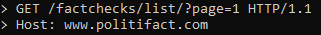

Upon receiving the request, the server extracts the webpage and sends back a response message to the client.

HTTP server response messages follow a fixed syntax, which is as follows:
* A status line: (with the following space separated elements)
    * Protocol version
    * Response status code
    * Reason phrase. This can be empty.
* Response header fields, each in a separate line. All headers are optional.
* An empty line
* An optional message body

Hence, for our webpage, the initial lines of the response will look something like:

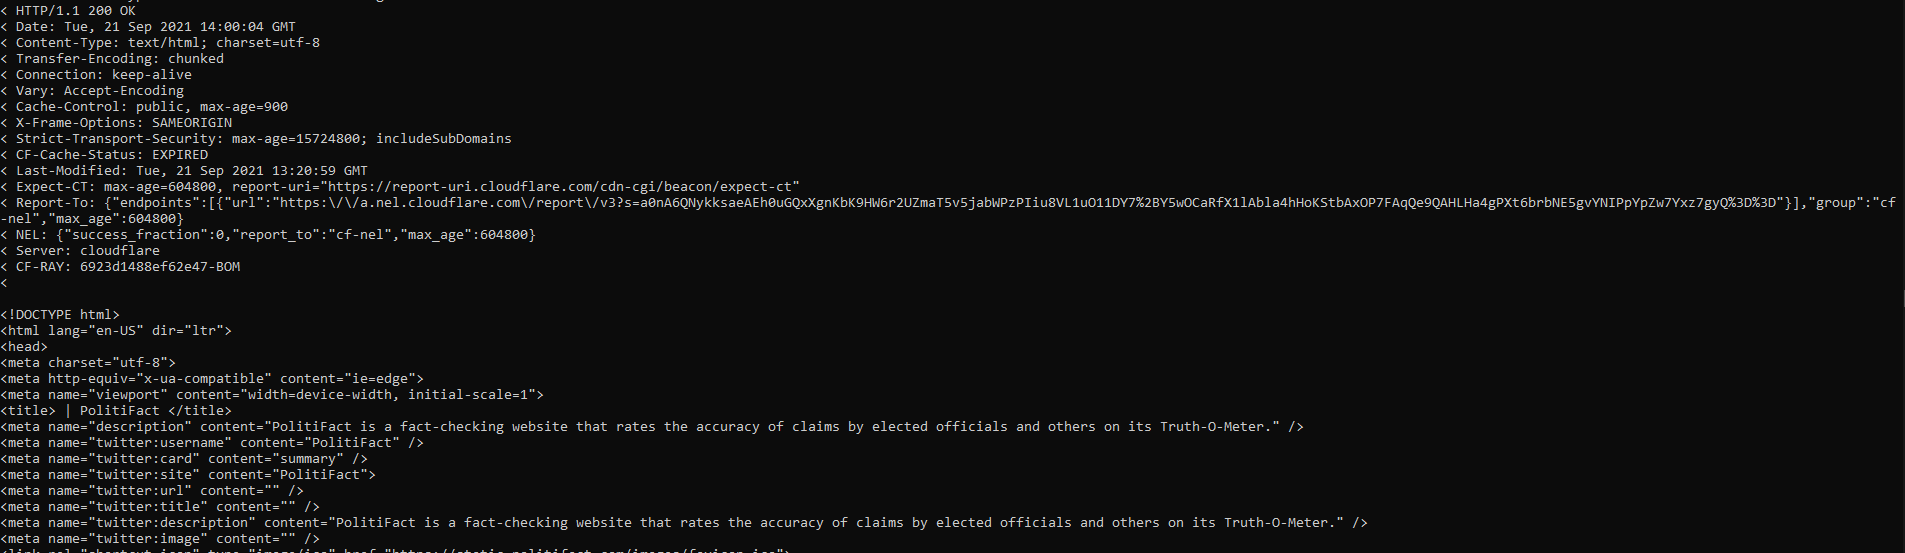

#### Identifying the relevant data from the HTML document

Almost all webpages are written with HTML (Hyper Text Markup Language), with some assistance from CSS, XML, Javascript and other languages. You can see that the first line of the message body says `<!DOCTYPE html>`, indicating that our webpage is primarily created in HTML.

HTML documents use tags to structure the webpage. Tags are of the form `<...>`. Many tags also have closing tags to enclose text between them. Closing tags are of the form `</...>`. Generally, elements and content of the same type will be enclosed in the same tags. To verify this and identify the tags relevant to us, we use the `Inspect` feature in our browser, with the relevant page open.

Inspecting the first fact-check in the list, we see the following:

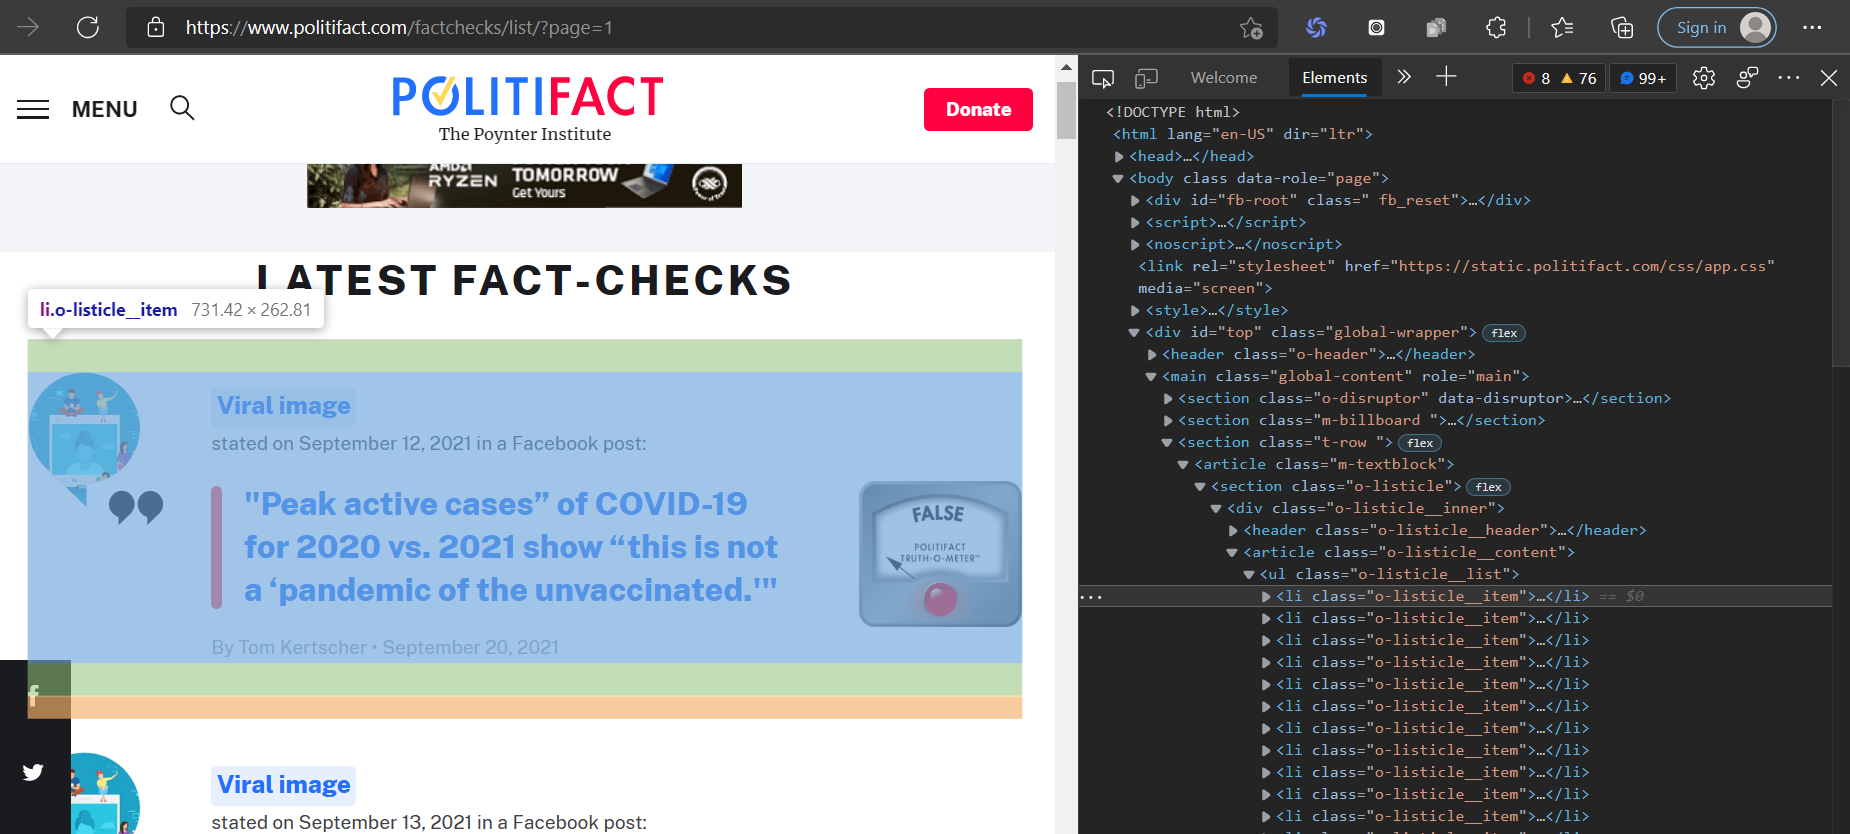

As you can observe, our fact-checks are saved in the tag `<li class="o-listicle__item">`. From here, it is easy to see where the individual data labels can be found. We can iterate this process for all tags of the given type, and then iterate it over a number of pages to collect a significant amount of data.

Now that we know the process that goes on behind the scenes, let's move forward with implementing it in Python.

## The BeautifulSoup Package

The `BeautifulSoup` package is a vital component in our program. `BeautifulSoup` is a Python package that can parse HTML and XML documents. While the name might sound weird, the reason for its name is also the reason why it's important. For historical reasons, web browsers don't generally enforce HTML strictly. While this hardly bothers the average user, the malformed markup can cause trouble for normal parsers. This malformed markup is also called tag soup and this is where `BeautifulSoup` gets its name from, because it can interpret tag soup just like a HTML document with proper syntax. What `BeautifulSoup` does is transform the HTML document into a tree of tags, which makes it easy and efficient to carry out searches and extract elements.
Hence, let's import the package.

In [1]:
from bs4 import BeautifulSoup

## The requests Library

The `requests` library makes it easy for users to send and receive HTTP requests via Python. Let's import the library.

In [2]:
import requests

## The pandas Library

The `pandas` library is used for data manipulation and analysis. It offers data structures and operations to manage tables and time series. It contains the data structure DataFrame and functions to import and export their content to and from various different types of files. Let's import this library too.

In [3]:
import pandas as pd

## The Program

##### Initialise the number of pages to scrape

We need to scrape a number of pages in order to collect a decently sized database. Here we initialize the number as `10`.

In [4]:
pagesToGet = 10

##### Initialising the container list for our data

While we shall be using the `pandas` `DataFrame` object to interface with our data, the `DataFrame` object is inefficient in taking inputs directly. Hence, we will store our data in a list before converting it to a `DataFrame`. We will initialize this list now.

In [5]:
upperframe = []

##### Scraping a page

While we need to scrape a number of webpages, for simplicity of explanation, we will first scrape one page as a demonstration before running the actual loop over all the pages.

Let's choose the very first page to scrape, and display it.

In [6]:
page = 1
print('processing page :', page)

processing page : 1


Next, we'll save our URL in a string. As you might remember from a previous section, our initial seed is `https://www.politifact.com/factchecks/list/?page=1`. Since we need to iterate over pages, we will take `https://www.politifact.com/factchecks/list/?page=` and append the page number to it. Since, we have the page number in the integer variable `page`, we will first cast it into a string before appending it.

In [7]:
url = 'https://www.politifact.com/factchecks/list/?page=' + str(page)
print(url)

https://www.politifact.com/factchecks/list/?page=1


The next step is to retrieve the content of the webpage at the URL. For this we shall use the `get()` function from the `requests` library. This saves a `Response` object in the variable which contains the HTTP response from the server, including the HTML document.

In [8]:
page = requests.get(url)
print(page)

<Response [200]>


Now, our next step is to parse the HTML document. For this we shall pass our document to the `BeautifulSoup` constructor with the default HTML parser for Python. We can obtain the HTML document from the `Response` object using the `text` property of the object. The default parser is indicated by `'html.parser'`.

In [9]:
soup = BeautifulSoup(page.text,'html.parser')

Next, we need to initialize a new list to store the data from this page.

In [10]:
frame = []

Since all of the data we require for a single fact-check in the list is contained in `<li class="o-listicle__item">` tags, we will find all such tags. For this we use the `find_all()` method of the `BeautifulSoup` object, which returns a list of `tag` objects. We will also print the length of the list obtained to get the number of articles present on the page.

In [11]:
links=soup.find_all('li',attrs={'class':'o-listicle__item'})
print(len(links))

30


Next, we iterate through the list of tags and save the data we need in the form of tuples in the list we initialised for this page. For this we need to use the `find()` method. We will print the first member of the list to see how the elements are stored

In [12]:
for j in links:             
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
print(frame[0])

('Says the COVID-19 vaccine doesn’t “prevent catching or spreading” the virus “and only lasts months.”', 'https://www.politifact.com/factchecks/2021/sep/21/facebook-posts/covid-19-vaccines-work-even-if-they-arent-100-effe/', 'mber 21, 2021', 'Facebook posts', 'false')


Now, we extend the list we have for the entire website with the list of data from this specific page.

In [13]:
upperframe.extend(frame)

##### Scraping the required pages

Now that we have seen how the code works for the first page, we will run a loop for the pages we require, starting at the second.

In [14]:
for page in range(2,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(url)
    page=requests.get(url)
    sp1=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=sp1.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
    upperframe.extend(frame)

processing page : 2
https://www.politifact.com/factchecks/list/?page=2
30
processing page : 3
https://www.politifact.com/factchecks/list/?page=3
30
processing page : 4
https://www.politifact.com/factchecks/list/?page=4
30
processing page : 5
https://www.politifact.com/factchecks/list/?page=5
30
processing page : 6
https://www.politifact.com/factchecks/list/?page=6
30
processing page : 7
https://www.politifact.com/factchecks/list/?page=7
30
processing page : 8
https://www.politifact.com/factchecks/list/?page=8
30
processing page : 9
https://www.politifact.com/factchecks/list/?page=9
30
processing page : 10
https://www.politifact.com/factchecks/list/?page=10
30


##### Converting the data into a DataFrame

Now, we convert the data we have collected in a list into a `DataFrame`. For this we use the `DataFrame` constructor, giving it the list and the column labels for our data. We then print the first 5 rows using the `head()` method.

In [15]:
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label']) 
print(data.head())

                                           Statement  \
0  Says the COVID-19 vaccine doesn’t “prevent cat...   
1  “West Virginia University just came out with a...   
2  “The CDC and county health officials have obta...   
3  “President Biden has created more jobs in his ...   
4  The United States spent “2 trillion dollars to...   

                                                Link           Date  \
0  https://www.politifact.com/factchecks/2021/sep...  mber 21, 2021   
1  https://www.politifact.com/factchecks/2021/sep...  mber 21, 2021   
2  https://www.politifact.com/factchecks/2021/sep...  mber 21, 2021   
3  https://www.politifact.com/factchecks/2021/sep...  mber 21, 2021   
4  https://www.politifact.com/factchecks/2021/sep...  mber 21, 2021   

              Source       Label  
0     Facebook posts       false  
1  Jennifer Granholm   half-true  
2           Bloggers  pants-fire  
3         Gwen Moore   half-true  
4      Richard Ojeda   half-true  


##### Saving the data for future use

Since a `DataFrame` is available only while the current program is running, we will save it's contents in a `.csv` file. For this we use the `to_csv()` method.

In [16]:
data.to_csv('PolitiFacts.csv')

Open the file, and you can find your data saved in it.

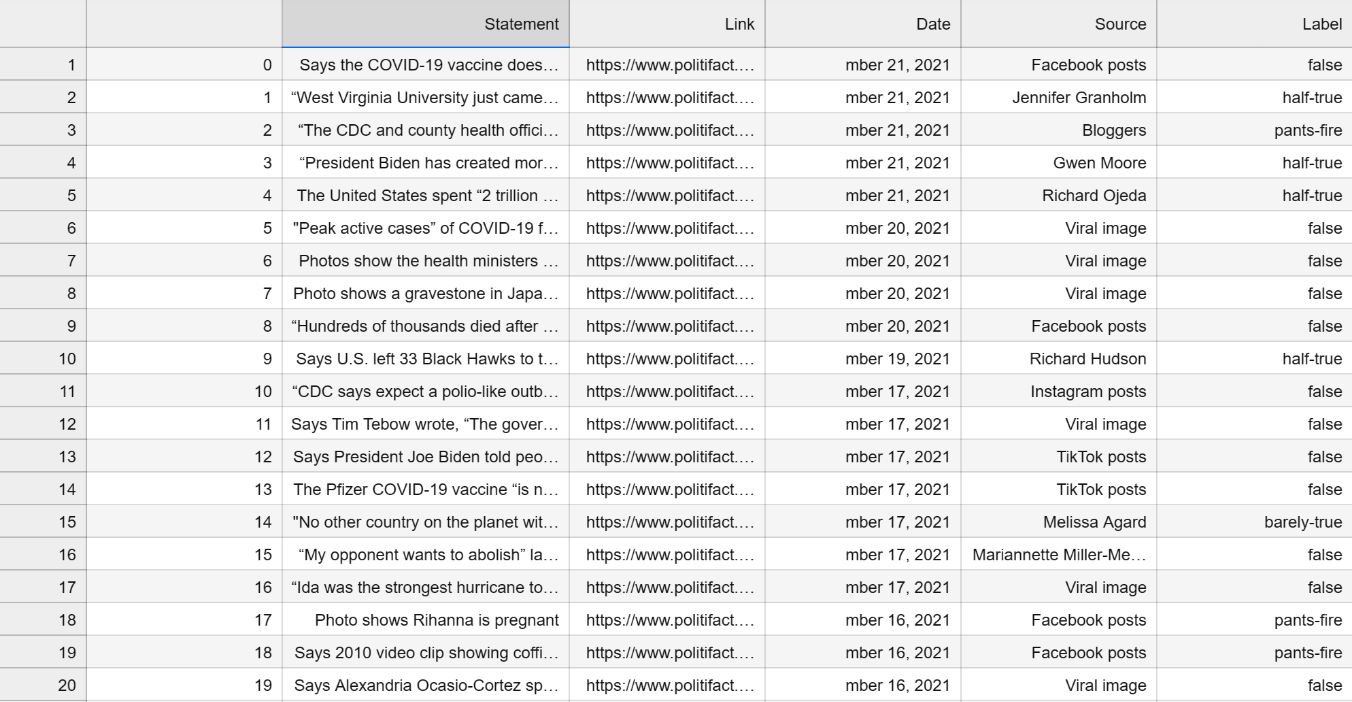

## Code for scraping other websites

The basic concept for scraping data doesn't change. You have to Inspect element in order to identify the specific tags you have to look for and modify your code accordingly. Some sites may be more complicated and require additional levels of searching for tags in order to function properly. As a further example, I will include the code for the other 2 websites I had mentioned earlier: The Guardian and OpIndia. A key difference is that we are extracting the full text of the article as well. This requires an additional page to be scraped for each article.

### Code for The Guardian

In [17]:
pagesToGet= 10                                              #This denotes the number of pages to be scanned, can be increased and decreased as per requirement

upperframe=[]                                               #Initialises a list to save the entire data of the website

for page in range(1,pagesToGet+1):                                              #Basic loop to cycle through the pages
    print('processing page :', page)                                            
    url = 'https://www.theguardian.com/world?page='+str(page)                   #Saves the URL of current page
    print(url)                                                                  
    page=requests.get(url)                                                      #Sends a request for the HTTP content of the current URL and saves it
    sp1=BeautifulSoup(page.text,'html.parser')                                  #Initialises a BeautifulSoup object to parse the HTML content saved from the URL
    frame=[]                                                                    #Intialises a blank list to stare the data of the current page
    links=sp1.find_all('div',attrs={'class':'fc-item__container'})             #Finds and stores all instances of the specified tag-attributes combination containing the article links
    print(len(links))                                                           #Prints the number of articles found on the page
    for j in links:             
        title = j.find("a").text.strip()                                        #Saves the title
        Link = j.find('a')['href'].strip()                                      #Saves the link
        Date = j.find("time")["datetime"][0:10]                                 #Saves the date
        ptemp = requests.get(Link)                                              #Requests the article page
        sp2 = BeautifulSoup(ptemp.text,'html.parser')                           #Initialises a second BeautifulSoup object to parse the article page
        text = ''                                                               #Initialises a blank string to store the article text
        kinks = sp2.find_all('p',attrs={'class':'dcr-s23rjr'})                  #Finds all tags containing the text
        for k in kinks:
            text += k.text.strip()                                              #Add the text from the current section to the blank string
        frame.append((title,text,Link,Date))                                    #Add a tuple with the title, text and the link of the current article to the list
    upperframe.extend(frame)                                                    #Appends the list of the current page to the list of the whole website
data=pd.DataFrame(upperframe, columns=['title','text','Link', 'Date'])          #Initialises a Pandas dataframe with the final collected list
nan_value = float("NaN")
data.replace("", nan_value, inplace=True)                                       #Replace "" with NaN in the text for pages with no news paragraphs
data.dropna(subset = ["text"], inplace=True)                                    #Drop pages with no text
data.to_csv('TheGuardian.csv')                                                          #Convert the dataframe to a CSV file
print(data.head())                                                              #Print the first 5 rows of the dataframe                                                     

processing page : 1
https://www.theguardian.com/world?page=1
20
processing page : 2
https://www.theguardian.com/world?page=2
20
processing page : 3
https://www.theguardian.com/world?page=3
20
processing page : 4
https://www.theguardian.com/world?page=4
20
processing page : 5
https://www.theguardian.com/world?page=5
20
processing page : 6
https://www.theguardian.com/world?page=6
20
processing page : 7
https://www.theguardian.com/world?page=7
20
processing page : 8
https://www.theguardian.com/world?page=8
20
processing page : 9
https://www.theguardian.com/world?page=9
20
processing page : 10
https://www.theguardian.com/world?page=10
20
                                               title  \
2  ‘Ecofeminism is about respect’: the activist w...   
3  Most Europeans believe US in new cold war with...   
4  Biden under pressure to close the ‘vaccination...   
6  Most infants in 91 countries are malnourished,...   
7  Developing nations welcome US climate finance ...   

                     

### Code for OpIndia

In [25]:
pagesToGet= 10                                              #This denotes the number of pages to be scanned, can be increased and decreased as per requirement

upperframe=[]                                               #Initialises a list to save the entire data of the website

for page in range(1,pagesToGet+1):                                              #Basic loop to cycle through the pages
    print('processing page :', page)                                            
    url = 'https://www.opindia.com/latest-news/page/'+str(page)+'/?nocache'     #Saves the URL of current page
    print(url)                                                                  
    page=requests.get(url)                                                      #Sends a request for the HTTP content of the current URL and saves it
    sp1=BeautifulSoup(page.text,'html.parser')                                  #Initialises a BeautifulSoup object to parse the HTML content saved from the URL
    frame=[]                                                                    #Intialises a blank list to stare the data of the current page
    links=sp1.find_all('div',attrs={'class':'tdb_module_loop td_module_wrap td-animation-stack'})   #Finds and stores all instances of the specified tag-attributes combination containing the article links
    print(len(links))                                                                       #Prints the number of articles found on the page
    for j in links:             
        title = j.find('div',attrs={'class':'td-module-meta-info'}).find("h3",attrs={'class':'entry-title td-module-title'}).text.strip()               #Saves the title
        Link = j.find('div',attrs={'class':'td-module-meta-info'}).find("h3",attrs={'class':'entry-title td-module-title'}).find('a')['href'].strip()   #Saves the link
        Date = j.find('span', attrs={'class':'td-author-date'}).find('span', attrs={'class':'td-post-date'}).find("time")["datetime"][0:10]                                 #Saves the date
        ptemp = requests.get(Link)                                              #Requests the article page
        sp2 = BeautifulSoup(ptemp.text,'html.parser')                           #Initialises a second BeautifulSoup object to parse the article page
        text = ''                                                               #Initialises a blank string to store the article text
        kinks = sp2.find_all('p')                                               #Finds all tags containing the text
        for k in kinks:
            text += k.text.strip()                                              #Add the text from the current section to the blank string
        frame.append((title,text,Link, Date))                                         #Add a tuple with the title, text and the link of the current article to the list
    upperframe.extend(frame)                                                    #Appends the list of the current page to the list of the whole website
data=pd.DataFrame(upperframe, columns=['title','text','Link','Date'])                  #Initialises a Pandas dataframe with the final collected list
data.to_csv('OpIndia.csv')                                                          #Convert the dataframe to a CSV file
print(data.head())                                                              #Print the first 5 rows of the dataframe

processing page : 1
https://www.opindia.com/latest-news/page/1/?nocache
50
processing page : 2
https://www.opindia.com/latest-news/page/2/?nocache
50
processing page : 3
https://www.opindia.com/latest-news/page/3/?nocache
50
processing page : 4
https://www.opindia.com/latest-news/page/4/?nocache
50
processing page : 5
https://www.opindia.com/latest-news/page/5/?nocache
50
processing page : 6
https://www.opindia.com/latest-news/page/6/?nocache
50
processing page : 7
https://www.opindia.com/latest-news/page/7/?nocache
50
processing page : 8
https://www.opindia.com/latest-news/page/8/?nocache
50
processing page : 9
https://www.opindia.com/latest-news/page/9/?nocache
50
processing page : 10
https://www.opindia.com/latest-news/page/10/?nocache
50
                                               title  \
0  Supreme Court stays NCDRC order directing YRF ...   
1  Assam government sends the message that rhino ...   
2  Taliban writes to UN demanding to be invited t...   
3  Centre allows bureauc